# Plug-and-Play Image Restoration

<a target="_blank" href="https://colab.research.google.com/github/esoubies/TP_INSA/blob/master/TP_1_Image_PnP_Unroll.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This practical session is dedicated to the implementation of plug-and-play algorithms with pre-learned denoisers.
They will be illustrated on deblurring problems using deepinv library.

The outline of the session is:
1. Coding a blur model and testing a pretrained denoiser
2. Implementing a PnP PGD
3. Implementing a PnP HQS

Practical informations:
1. In torch the image format is B x C x H x W where
  - B is the batch size
  - C is the number of channels (C=1 for grayscale C = 3 for RGB)
  - H is the number of pixels in the vertical direction
  - W is the number of pixels in the horizontal direction
2. To take advantage of the GPU acceleration, make sure to pass the `device` variable to the torch functions. For example,
`x = torch.zeros((1,1,25,25))` creates an image of size (1,1,25,25) on the cpu than can be transfered to the GPU using `x = x.to('cuda')`.
The image can directly by created on the GPU using `x = torch.zeros((1,1,25,25), device = 'cuda')`
In the following code block, the variable `device` is created to easily swith from CPU to GPU. You can use it in your code instead of hard coding 'cpu' 'cuda'.

In [1]:
import numpy as np
import torch
from torch.fft import fft2, ifft2, fftshift, ifftshift

import matplotlib.pyplot as plt
import time

import torch
print(torch.__version__)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

!pip install git+https://github.com/deepinv/deepinv.git
import deepinv as dinv
from deepinv.physics.generator import MotionBlurGenerator

psnr = dinv.loss.PSNR()

2.8.0+cu126
cuda
  Cloning https://github.com/deepinv/deepinv.git to /tmp/pip-req-build-tzovaxyi
  Running command git clone --filter=blob:none --quiet https://github.com/deepinv/deepinv.git /tmp/pip-req-build-tzovaxyi
  Resolved https://github.com/deepinv/deepinv.git to commit 3c6c9fa29143649a70c2fcc8a50c4a164f0149c4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 25.4 MB/s eta 0:00:00
  Created wheel for deepinv: filename=deepinv-0.3.5-py3-none-any.whl size=807609 sha256=680ce95e1a24a9ac01de514d0c0ec8c0084e95a046275778d2995ed07a5560ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-256r463d/wheels/84/8d/78/3f46551e7c8c141353bd628df44fbeb33820f3b5a4a2da7e2a
Successfully built deepinv


<br/><br/><br/>

# Part 1: Blur model and pretrained denoiser

## Test a pre-learned denoiser

In this section, we load an image and pretrained denoiser from the deepinv library. The denoiser is tested on a denoising problem.


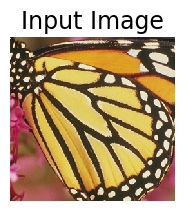

In [2]:
## Open the image
url = dinv.utils.demo.get_image_url("butterfly.png") # Other images are available here : https://huggingface.co/datasets/deepinv/images
x0 = dinv.utils.demo.load_url_image(url, grayscale=False).to(device)

# Plot image
dinv.utils.plot(x0,'Input Image')

There are three possible denoisers in deepinv: DRUnet, DnCNN, TV.
You can select one by commenting/decommenting the appropriate lines and play with the three during the session.

In [45]:

# Load the DRUNet denoiser
# https://deepinv.github.io/deepinv/stubs/deepinv.models.DRUNet.html
D1 = dinv.models.DRUNet(pretrained='download').to(device)


# Load the DnCNN denoiser (WARNING: the proposed weights are only trained for noise level sigma = 2/255)
# https://deepinv.github.io/deepinv/stubs/deepinv.models.DnCNN.html
D2 = dinv.models.DnCNN(pretrained='download').to(device)

# TV denoiser (only in last version of deepinv)
Dtv = dinv.models.TVDenoiser().to(device)
def D(x,sigma):
  return Dtv(x,ths=2*sigma**2)



**Compute** a noisy image
$$ y = x_0 + \xi $$
where $\xi \sim \mathcal{N}(0,\sigma^2 \mathsf{Id})$.

Denoise the image $y$ by using a pre-learned denoiser for different level of noise $\sigma^2$.

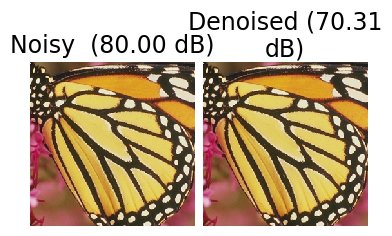

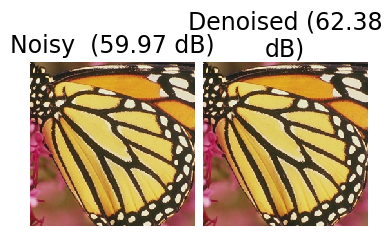

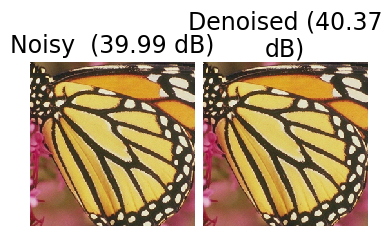

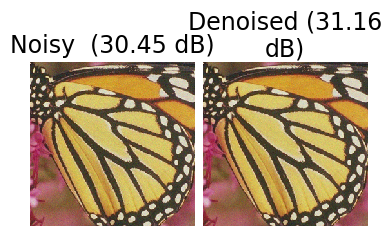

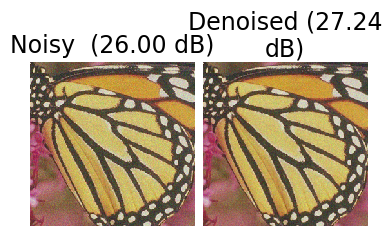

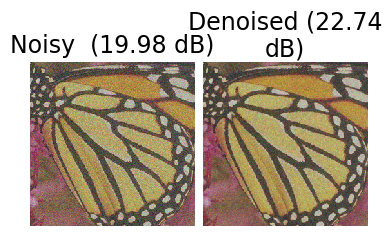

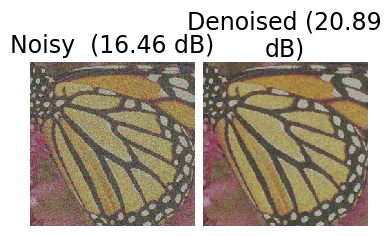

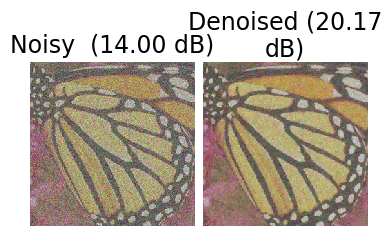

[80.0, 59.97, 39.99, 30.45, 26.0, 19.98, 16.46, 14.0]
[70.31, 62.38, 40.37, 31.16, 27.24, 22.74, 20.89, 20.17]


In [47]:
# sigmas_DNCNN = [2/255]
sigmas_DRUNET = [0., 0.001, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]# in [0, 0.2]
psnr_x0_y = []
psnr_x0_Dy = []

for sigma in sigmas_DRUNET:
  y = x0 + sigma*torch.randn_like(x0)
  Dy = D(y,sigma)
  psnr_x0_y.append(round(psnr(x0,y).item(),2))
  psnr_x0_Dy.append(round(psnr(x0,Dy).item(),2))

  dinv.utils.plot([y,Dy],
   [f'Noisy  (%.2f dB)'%psnr(x0,y),
    'Denoised (%.2f dB)'%psnr(x0,Dy)])

print(psnr_x0_y)
print(psnr_x0_Dy)


> Résultats pour DnCNN (sigma = 2/255 uniquement)
- On a PSNR(x0,y) = 42.1 dB et PSNR(x0,Dy) = 45.25 dB, le gain est modéré


> Résultats pour DRUNet :

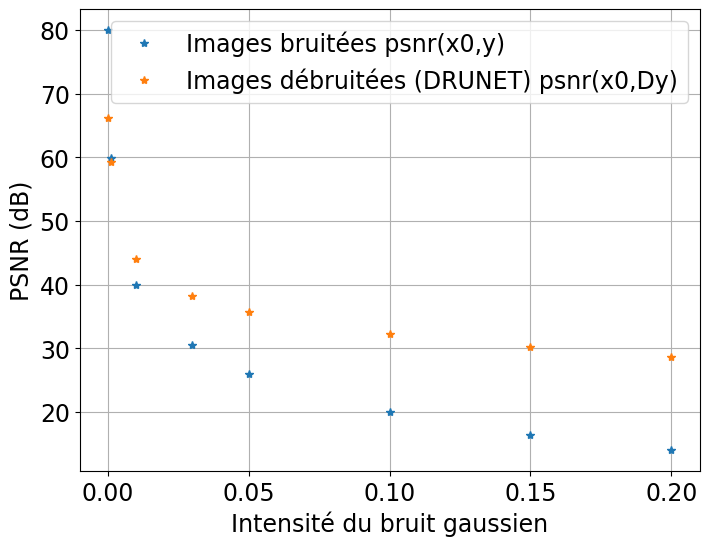

In [42]:
sigmas_DRUNET = [0., 0.001, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]
DRUNET_dB_bruit = [80.0, 59.95, 40.01, 30.45, 26.01, 20.01, 16.44, 13.98]
DRUNET_db_debruite = [66.17, 59.23, 44.0, 38.21, 35.7, 32.25, 30.16, 28.7]

plt.figure(figsize=(8,6))
plt.plot(sigmas_DRUNET,DRUNET_dB_bruit,'*',label = "Images bruitées psnr(x0,y)")
plt.plot(sigmas_DRUNET,DRUNET_db_debruite,'*',label = "Images débruitées (DRUNet) psnr(x0,Dy)")
plt.xlabel("Intensité du bruit gaussien")
plt.ylabel("PSNR (dB)")
plt.grid()
plt.legend()
plt.show()

- Avec PSNR(x0,y) on mesure la dégradation de l'image originale, introduite par le bruit
- Avec PSNR(x0,Dy) on évalue la performance du débruiteur
- Lorsque sigma = 0, DRUNet ne renvoie pas un PSNR de 80 dB, car DRUNet n'est pas une fonction identitée, il n'a pas été entraîné à laisser intacte une image propre (car il n'a jamais vu de bruit nul durant l'entraînement)
- Donc même sans bruit, il applique un léger lissage ou une supression de détails qu'il considère comme anormaux
- Pour sigma allant de 0.03 à 0.1, DRUNet apporte un gain de +8 à +12 dB
- Pour sigma >= 0.15, le gain en dB est stable à +16 dB
- DRUNet semble donc être efficace et robuste à une large gamme de niveaux de bruit (du moins celle pour laquelle il a été entraîné)


> Résultats pour TVDenoiser (même sigmas que pour DRUNet) :

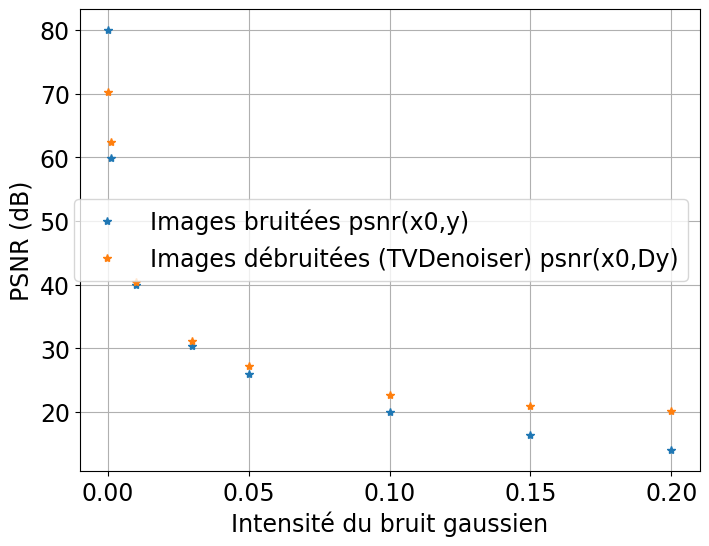

In [49]:
sigmas_DTV = [0., 0.001, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2] #memes valeurs que pour DRUNet
DTV_dB_bruit = [80.0, 59.97, 39.99, 30.45, 26.0, 19.98, 16.46, 14.0]
DTV_db_debruite = [70.31, 62.38, 40.37, 31.16, 27.24, 22.74, 20.89, 20.17]

plt.figure(figsize=(8,6))
plt.plot(sigmas_DTV,DTV_dB_bruit,'*',label = "Images bruitées psnr(x0,y)")
plt.plot(sigmas_DTV,DTV_db_debruite,'*',label = "Images débruitées (TVDenoiser) psnr(x0,Dy)")
plt.xlabel("Intensité du bruit gaussien")
plt.ylabel("PSNR (dB)")
plt.grid()
plt.legend()
plt.show()

- Le PSNR, après application du TVDenoiser, reste supérieur au PSNR de l'image brutiée dès que le bruit est >= 0.05
- Mais le gain est modeste, on varie entre +2dB à +6dB pour sigma allant de 0.05 à 0.20
- Comme pour DRUNet, le PSNR se stabilise pour sigma >= 0.15

## Blur model

This section generates a motion blur kernel from the deepinv library.

In [ ]:
## Generate a motion blur
torch.manual_seed(1)  # fix random seed for reproducibility
generator = MotionBlurGenerator((25, 25), num_channels=1, sigma = 0.5)
blur = generator.step(seed = 1)
kt = blur['filter']

# Embed the kernel in a MxNx3 image, and put center at pixel (0,0)
k = torch.zeros_like(x0)
m,n = kt.shape[-2:]
k[:,:,0:m,0:n] = kt/torch.sum(kt)
k = torch.roll(k,(-int(m/2),-int(n/2)),(-2,-1))

# Display kernel
dinv.utils.plot([kt, fftshift(k,dim=(-2,-1))],['Blur kernel [25 x 25]','Blur kernel [M N]'])


The forward model is:
$$ y = k \star x_0 + \xi $$
where $\xi \sim \mathcal{N}(0,\sigma^2 \mathsf{Id})$ and $k$ is the generated blur kernel.

Implement the code generating $y$ using the Fast Fourier Transform. (You can look at the documentation of `torch.fft.fft2`)

In [ ]:
sigma = 0.1#2/255  # noise level

# Draw a sample of the direct model for image deblurring (apply blur and add Gaussian noise)
y = ...

dinv.utils.plot(y,'Blur and noisy image')

# Part 2: Image deblurring with PnP-PGD

In this section, you will implement a PnP proximal gradient descent (PnP-PGD) to solve the deblurring problem. The iteration is given by :
$$ x_{k+1} = D_\eta \circ (\operatorname{Id} - \tau \nabla f) (x_k) $$
where
- $f$ is the data fidelity term defined by $f(x) = \frac{1}{2\sigma^2} \|k \star x - y\|_2^2$.
- $D_\eta$ is the denoiser of level $\eta$
- $\tau$ is the step-size and should be chosen such that $\tau < \frac{2}{L}$ with $L$ the Lipschitz constant of $\nabla f$.

Complete the following cell to
1. Implement PnP-PGD iteration
2. Store the PSNR of the reconstruction at each iteration

Try to find the best $\tau$ and $\eta$ and number of iterations. Test the other denoisers and comment.

In [ ]:
tau =  # step-size
eta =  # strength of the denoiser

# initialize with blurry image
x = y.clone()

psnrtab = []  # to store psnr

niter =  # number of iterations
t0 = time.time()
print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(0,niter,0.,psnr(x0,y)))

for it in range(niter):
    # before calling the denoiser, use with torch.no_grad() to avoid computing the gradient with respect to the weights of the denoising network
    with torch.no_grad():
      x = # PnP-PGD iteration

    psnrtab.append(psnr(x0,x))

    if (it+1)%10==0:
        print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(it+1,niter,time.time()-t0,psnrtab[it]))
        dinv.utils.plot(x,'Iteration %i'%it)

plt.plot(torch.tensor(psnrtab))
plt.title('PSNR')
plt.show()


# Part 3: Image deblurring with PnP-HQS

In this section, you will implement a PnP Half Quadratic Splitting (PnP-HQS) to solve the deblurring problem. The iteration is given by :
$$ x_{k+1} = D_{\eta} \circ \mathsf{Prox}_{\tau f} (x_k) $$
where
- $f$ is the data fidelity term defined by $f(x) = \frac{1}{2\sigma^2} \|k \star x - y\|_2^2$.
- $D_\eta$ is the denoiser of level $\eta$
- $\tau$ is the penalty parameter



Before coding the PnP-HQS, we advise to create a function that implements the proximal operator of the data-fidelity term:
$$\mathsf{Prox}_{\tau f}(x) = \left(\frac{1}{\sigma^2} A^T A + \tau \mathsf{Id} \right)^{-1} \left( \frac{1}{\sigma^2} A^T y + \tau x \right) .$$

In [ ]:
def proxf(x, tau, sigma, fAtA, fAty):


Complete the following cell to
1. Implement PnP-HQS iteration
2. Store the PSNR of the reconstruction at each iteration

Try to find the best $\tau$ and $\eta$ and number of iterations. Test the other denoisers and comment.

In [ ]:
tau =  # penalty parameter
eta =  # strength of the denoiser

# initialize with blurry image
x = y.clone()

psnrtab = []  # to store psnr
rtab = []     # to store residual

niter = # number of iteration
t0 = time.time()
print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(0,niter,0.,psnr(x0,y)))

for it in range(niter):

    with torch.no_grad():
      x = # HQS iteration

    psnrtab.append(psnr(x0,x))

    if (it+1)%10==0:
        print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(it+1,niter,time.time()-t0,psnrtab[it]))
        dinv.utils.plot(x,'Iteration %i'%it)

plt.plot(torch.tensor(psnrtab))
plt.title('PSNR')
plt.show()